In [22]:
#基于机器学习的简单交易策略
#导入 pandas
import pandas as pd
#导入绘图库
import matplotlib.pyplot as plt
#导入金融数据获取模块 AKShare
import akshare as ak
import numpy as np
#导入数据集拆分工具
from sklearn.model_selection import train_test_split
#导入KNN分类模型
from sklearn.neighbors import KNeighborsClassifier

In [23]:
#定义一个加载股票数据的函数
def load_stock(start_date, end_date, output_file, symbol='1.601816'):
    try:
        df = pd.read_pickle(output_file)
        print("载入本地数据完毕")
    except FileNotFoundError:
        print("本地文件未找到，开始下载数据...")
        # 分离市场标识和股票代码
        market, code = symbol.split('.')
        df = ak.stock_zh_a_hist(
            symbol=code,
            period='daily',
            start_date=start_date,
            end_date=end_date,
            adjust='hfq'
        )
        df.to_pickle(output_file)
        print("数据下载并保存成功")
    return df

# 使用示例
jhgt = load_stock(
    start_date='20220101',
    end_date='20240101',
    output_file='601816.pkl',
    symbol='1.601816'  # 明确指定市场标识
)

载入本地数据完毕


In [24]:
#查看数据的前 5 行
jhgt.head()
#确保日期是索引
#jhgt = jhgt.set_index('日期')

,日期,股票代码,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率
0,2022-01-04,601816,4.90,4.99,5.01,4.89,584547,284880608.0,2.44,1.42,0.07,0.21
1,2022-01-05,601816,4.99,4.99,5.10,4.95,883436,436220384.0,3.01,0.00,0.00,0.32
2,2022-01-06,601816,4.99,4.95,5.01,4.93,478724,232937439.0,1.60,-0.80,-0.04,0.18
3,2022-01-07,601816,4.95,5.02,5.05,4.95,613379,302160304.0,2.02,1.41,0.07,0.22
4,2022-01-10,601816,4.99,5.05,5.06,4.92,519800,255036246.0,2.79,0.60,0.03,0.19


In [25]:
#下面定义一个用于分类的函数，给数据表增加三个字段
#首先是开盘价减去收盘价，命名为 open-close
#其次是最高价减去最低价，命名为 high-low
def classification_tc(df):
    df['open-close'] = df['开盘'] - df['收盘']
    df['high-low'] = df['最高'] - df['最低']

    #添加一个 target 字段，如果次日收盘价高于当日收盘价，则标记为 1 ，否则标记为 -1 
    df['target'] = np.where(df['收盘'].shift(-1) > df['收盘'], 1, -1)

    #去掉有空值的行
    df = df.dropna()

    #将 open-close 和 high-low 作为数据集的特征
    X = df[['open-close','high-low']]

    #将 target 赋值给 y
    y = df['target']

    #将 X 于 y 返回
    return (X, y)

In [26]:
#下面定义一个用于回归的函数
#特征的添加与分类函数类似
#只不过 target 字段改为次日收盘价减去当日收盘价
def regression_tc(df):
    df['open-close'] = df['开盘'] - df['收盘']
    df['high-low'] = df['最高'] - df['最低']
    df['target'] = df['收盘'].shift(-1) - df['收盘']
    df = df.dropna()
    X = df[['open-close', 'high-low']]
    y = df['target']
    #将 X 和 y 返回
    return (X, y)

In [27]:
#使用classification_tc函数生成数据集的特征与目标
X, y = classification_tc(jhgt)

#将数据集拆分为训练集与验证集
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [28]:
#创建一个 KNN 实例， n_neighbors 取 95 
knn_clf = KNeighborsClassifier(n_neighbors= 95)

#使用 KNN 拟合训练集
knn_clf.fit(X_train, y_train)

#输出模型在训练集中的准确率
print("模型在训练集中的准确率：%f"%knn_clf.score(X_train, y_train))
print("模型在验证集中的准确率：%f"%knn_clf.score(X_test, y_test))


模型在训练集中的准确率：0.568475
模型在验证集中的准确率：0.505155


In [29]:
#使用 KNN 模型预测每日股票的涨跌，保存为 Predict_Signal
jhgt['Predict_Signal'] = knn_clf.predict(X)

#在数据集中添加一个字段，用当日收盘价除以前一日收盘价，并取其自然对数
jhgt['Return'] = np.log(jhgt['收盘']/jhgt['收盘'].shift(1))
#查看一下
jhgt.head()

,日期,股票代码,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率,open-close,high-low,target,Predict_Signal,Return
0,2022-01-04,601816,4.90,4.99,5.01,4.89,584547,284880608.0,2.44,1.42,0.07,0.21,-0.09,0.12,-1,-1,NaN
1,2022-01-05,601816,4.99,4.99,5.10,4.95,883436,436220384.0,3.01,0.00,0.00,0.32,0.00,0.15,-1,-1,0.000000
2,2022-01-06,601816,4.99,4.95,5.01,4.93,478724,232937439.0,1.60,-0.80,-0.04,0.18,0.04,0.08,1,1,-0.008048
3,2022-01-07,601816,4.95,5.02,5.05,4.95,613379,302160304.0,2.02,1.41,0.07,0.22,-0.07,0.10,1,-1,0.014042
4,2022-01-10,601816,4.99,5.05,5.06,4.92,519800,255036246.0,2.79,0.60,0.03,0.19,-0.06,0.14,-1,-1,0.005958


In [30]:
#定义一个计算累计基准收益的函数
def cum_return(df, split_value):
    #该股票的基本收益为 Return 的总和除以 100 ，这里只计算预测集的结果
    cum_return = df[split_value:]['Return'].cumsum() * 100 
    #将计算结果进行返回
    return cum_return

In [31]:
#定义一个计算使用策略交易的收益
def strategy_return(df, split_value):
    #使用策略交易的收益为，模型 Return 乘以模型预测的涨跌幅
    df['Strategy_Return'] = df['Return'] * df['Predict_Signal'].shift(1)
    #将每日策略交易的收益加和并乘以 100 
    cum_strategy_return = df[split_value:]['Strategy_Return'].cumsum() * 100 
    #将计算结果进行返回
    return cum_strategy_return

In [32]:
#定义一个绘图函数，用来对比基准收益和算法交易的收益
def plot_chart(cum_return, cum_strategy_return, symbol):
    #首先定义画布的尺寸
    plt.figure(figsize = (9, 6))

    #使用折线图绘制基准收益
    plt.plot(cum_return, '--', label = '%s returns' % symbol)
    #使用折线图绘制算法交易收益
    plt.plot(cum_strategy_return, label = 'Strategy Returns')

    #添加图注
    plt.legend()
    #显示图像
    plt.show()
    

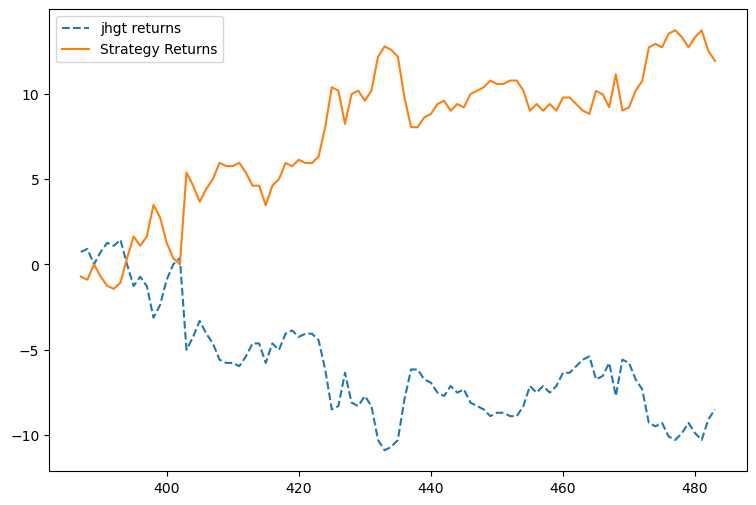

In [33]:
#首先计算基准收益（预测集）
sum_return = cum_return(jhgt, split_value = len(X_train))
#然后计算使用算法交易带来的收益（同样只计算预测集）
sum_strategy_return = strategy_return(jhgt, split_value = len(X_train))
#用图像来进行对比
plot_chart(sum_return, sum_strategy_return, 'jhgt')
